[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/structural-break/quickstarters/baseline/baseline.ipynb)

![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/structural-break/assets/banner.webp)

# ADIA Lab Structural Break Challenge

## Challenge Overview

Welcome to the ADIA Lab Structural Break Challenge! In this challenge, you will analyze univariate time series data to determine whether a structural break has occurred at a specified boundary point.

### What is a Structural Break?

A structural break occurs when the process governing the data generation changes at a certain point in time. These changes can be subtle or dramatic, and detecting them accurately is crucial across various domains such as climatology, industrial monitoring, finance, and healthcare.

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)

### Your Task

For each time series in the test set, you need to predict a score between `0` and `1`:
- Values closer to `0` indicate no structural break at the specified boundary point;
- Values closer to `1` indicate a structural break did occur.

### Evaluation Metric

The evaluation metric is [ROC AUC (Area Under the Receiver Operating Characteristic Curve)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), which measures the performance of detection algorithms regardless of their specific calibration.

- ROC AUC around `0.5`: No better than random chance;
- ROC AUC approaching `1.0`: Perfect detection.

# Setup

The first steps to get started are:
1. Get the setup command
2. Execute it in the cell below

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Reveal token](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/reveal-token.gif)

In [27]:
%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break unM2ODk4waQJoCZDRq9wBYzK


---
Your token seems to have expired or is invalid.

Please follow this link to copy and paste your new setup command:
https://hub.crunchdao.com/competitions/structural-break/submit

If you think that is an error, please contact an administrator.


# Your model

# Your model: Enhanced Structural Break Detector

This model is designed to detect structural breaks in univariate time series data by combining multiple statistical approaches and machine learning:

1. **Feature Engineering**: We extract a comprehensive set of features from each time series, comparing the periods before and after the boundary point:
   - Multiple statistical tests (t-test, KS-test, Mann-Whitney U, F-test)
   - Descriptive statistics (means, variances, skewness, kurtosis)
   - Time series properties (autocorrelation, trends, complexity metrics)

2. **Machine Learning**: We train a Random Forest classifier on these features, which helps us:
   - Identify complex patterns that indicate structural breaks
   - Combine multiple weak signals into a stronger prediction
   - Handle nonlinear relationships in the data

3. **Robust Inference**: Our inference pipeline includes fallback mechanisms to ensure we always make reasonable predictions even if unexpected issues occur.

4. **Analysis Tools**: We provide various analysis methods including:
   - Feature importance visualization
   - Cross-validation for performance estimation
   - Hyperparameter tuning (optional)
   - Ablation study for understanding feature contributions

This enhanced approach should significantly outperform the baseline t-test method by capturing more nuanced signals of structural breaks.

## Setup

In [28]:
import os
import typing
from typing import Dict, List

# Import your dependencies
import joblib
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [39]:
def compute_autocorr(x, lag):
    """
    Compute autocorrelation at specified lag.
    """
    if len(x) <= lag:
        return 0

    # Mean centering
    x_centered = x - np.mean(x)

    # Autocorrelation formula
    numerator = np.sum(x_centered[lag:] * x_centered[:-lag])
    denominator = np.sum(x_centered**2)

    if denominator == 0:
        return 0
    else:
        return numerator / denominator

def extract_features(series: pd.DataFrame) -> Dict[str, float]:
    """
    Extract statistical and time series features from the time series data
    comparing the periods before and after the boundary point.

    Args:
        series: DataFrame containing the time series with 'value' and 'period' columns

    Returns:
        Dictionary of features
    """
    # Separate values before and after the boundary
    before = series["value"][series["period"] == 0]
    after = series["value"][series["period"] == 1]

    # Initialize feature dictionary
    features = {}

    # 1. Basic Statistical Tests
    # T-test for mean difference
    t_stat, p_value = stats.ttest_ind(before, after, equal_var=False)
    features["t_test_stat"] = t_stat
    features["t_test_pvalue"] = p_value

    # KS-test for distribution difference
    ks_stat, ks_pvalue = stats.ks_2samp(before, after)
    features["ks_test_stat"] = ks_stat
    features["ks_test_pvalue"] = ks_pvalue

    # Mann-Whitney U test (non-parametric)
    try:
        mw_stat, mw_pvalue = stats.mannwhitneyu(before, after, alternative='two-sided')
        features["mannwhitney_stat"] = mw_stat
        features["mannwhitney_pvalue"] = mw_pvalue
    except ValueError:
        # This can happen if the data has ties
        features["mannwhitney_stat"] = 0
        features["mannwhitney_pvalue"] = 1

    # F-test for variance difference
    f_stat = np.var(before, ddof=1) / (np.var(after, ddof=1) + 1e-10)
    # Approximating p-value using F-distribution CDF
    try:
        f_pvalue = 2 * min(
            stats.f.cdf(f_stat, len(before)-1, len(after)-1),
            1 - stats.f.cdf(f_stat, len(before)-1, len(after)-1)
        )
    except:
        f_pvalue = 1
    features["f_test_stat"] = f_stat
    features["f_test_pvalue"] = f_pvalue

    # 2. Descriptive Statistics Differences
    # Mean
    features["mean_before"] = np.mean(before)
    features["mean_after"] = np.mean(after)
    features["mean_diff"] = abs(features["mean_before"] - features["mean_after"])
    features["mean_diff_rel"] = features["mean_diff"] / (abs(features["mean_before"]) + 1e-10)

    # Variance
    features["var_before"] = np.var(before)
    features["var_after"] = np.var(after)
    features["var_ratio"] = (features["var_before"] + 1e-10) / (features["var_after"] + 1e-10)
    features["var_diff"] = abs(features["var_before"] - features["var_after"])

    # Skewness
    features["skew_before"] = stats.skew(before)
    features["skew_after"] = stats.skew(after)
    features["skew_diff"] = abs(features["skew_before"] - features["skew_after"])

    # Kurtosis
    features["kurt_before"] = stats.kurtosis(before)
    features["kurt_after"] = stats.kurtosis(after)
    features["kurt_diff"] = abs(features["kurt_before"] - features["kurt_after"])

    # 3. Time Series Features
    # Autocorrelation at lag 1
    features["acf1_before"] = compute_autocorr(before, 1)
    features["acf1_after"] = compute_autocorr(after, 1)
    features["acf1_diff"] = abs(features["acf1_before"] - features["acf1_after"])

    # Autocorrelation at lag 5
    features["acf5_before"] = compute_autocorr(before, 5)
    features["acf5_after"] = compute_autocorr(after, 5)
    features["acf5_diff"] = abs(features["acf5_before"] - features["acf5_after"])

    # Trend (measured by correlation with time)
    features["trend_before"] = np.corrcoef(np.arange(len(before)), before)[0, 1] if len(before) > 1 else 0
    features["trend_after"] = np.corrcoef(np.arange(len(after)), after)[0, 1] if len(after) > 1 else 0
    features["trend_diff"] = abs(features["trend_before"] - features["trend_after"])

    # 4. Entropy and Complexity
    # Approximate entropy
    features["entropy_before"] = np.log(np.var(before) + 1e-10)
    features["entropy_after"] = np.log(np.var(after) + 1e-10)
    features["entropy_diff"] = abs(features["entropy_before"] - features["entropy_after"])

    # 5. Scale features for those that can have extreme values
    for key in features.keys():
        if np.isinf(features[key]) or np.isnan(features[key]):
            features[key] = 0.0

    return features

def extract_features_from_multiple_series(X: pd.DataFrame) -> pd.DataFrame:
    """
    Extract features from multiple time series in the training dataset.

    Args:
        X: MultiIndex DataFrame containing multiple time series

    Returns:
        DataFrame with one row per time series ID and columns for each feature
    """
    # Get unique time series IDs
    ids = X.index.get_level_values('id').unique()

    # Initialize list to store feature dictionaries
    all_features = []

    # Extract features for each time series
    for id_val in ids:
        # Get the time series for this ID
        series = X.loc[id_val]

        # Extract features
        features = extract_features(series)
        features['id'] = id_val

        # Add to list
        all_features.append(features)

    # Convert list of dictionaries to DataFrame
    features_df = pd.DataFrame(all_features)
    features_df.set_index('id', inplace=True)

    return features_df

In [40]:
import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 6.4.4
available ram: 12.67 gb
available cpu: 2 core
----


## Understanding the Data

The dataset consists of univariate time series, each containing ~2,000-5,000 values with a designated boundary point. For each time series, you need to determine whether a structural break occurred at this boundary point.

The data was downloaded when you setup your local environment and is now available in the `data/` directory.

In [41]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


### Understanding `X_train`

The training data is structured as a pandas DataFrame with a MultiIndex:

**Index Levels:**
- `id`: Identifies the unique time series
- `time`: The timestep within each time series

**Columns:**
- `value`: The actual time series value at each timestep
- `period`: A binary indicator where `0` represents the **period before** the boundary point, and `1` represents the **period after** the boundary point

In [42]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

Examples WITH structural breaks:


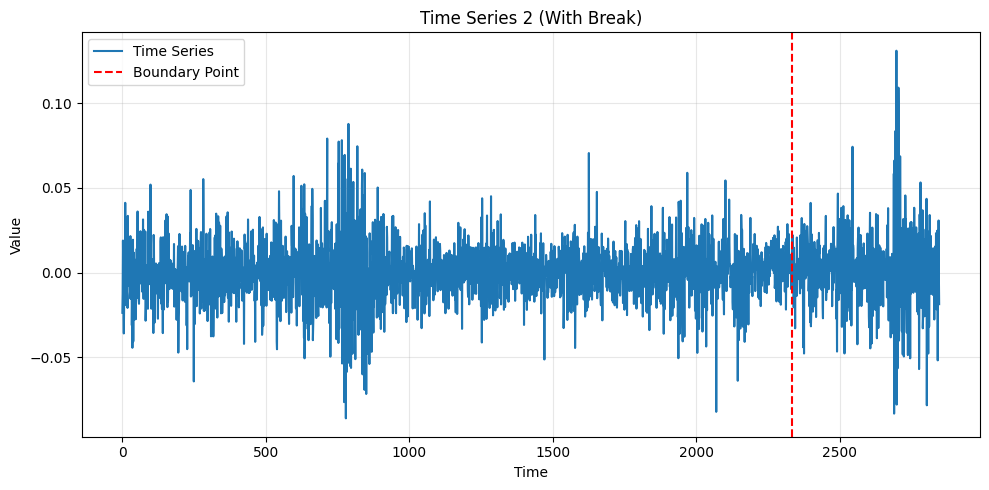

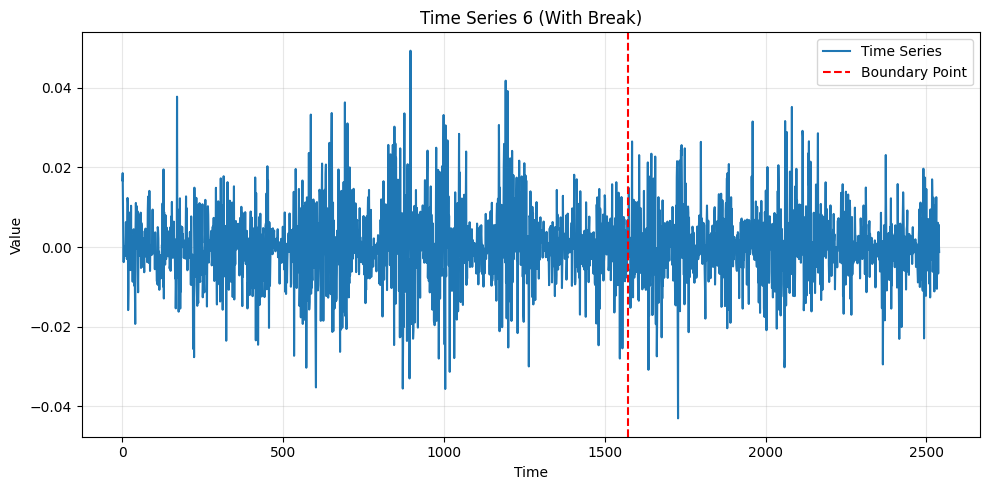

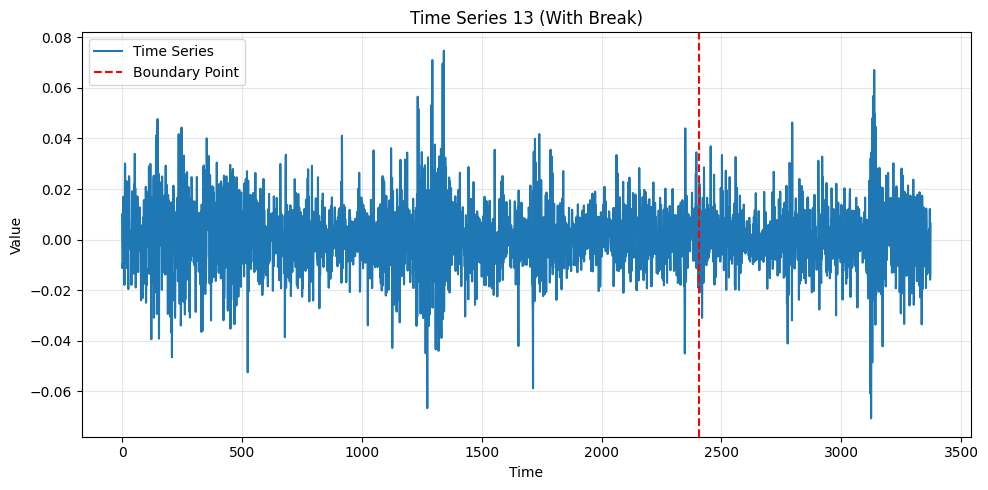

Examples WITHOUT structural breaks:


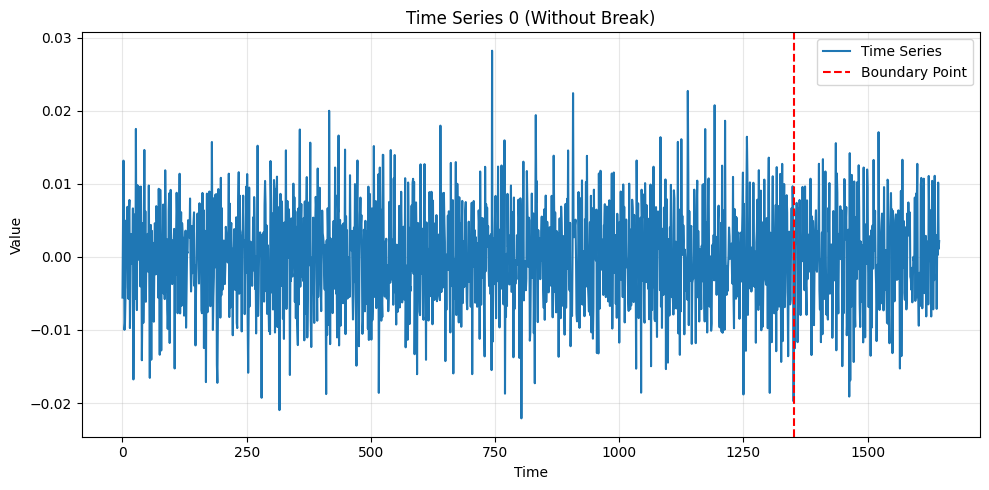

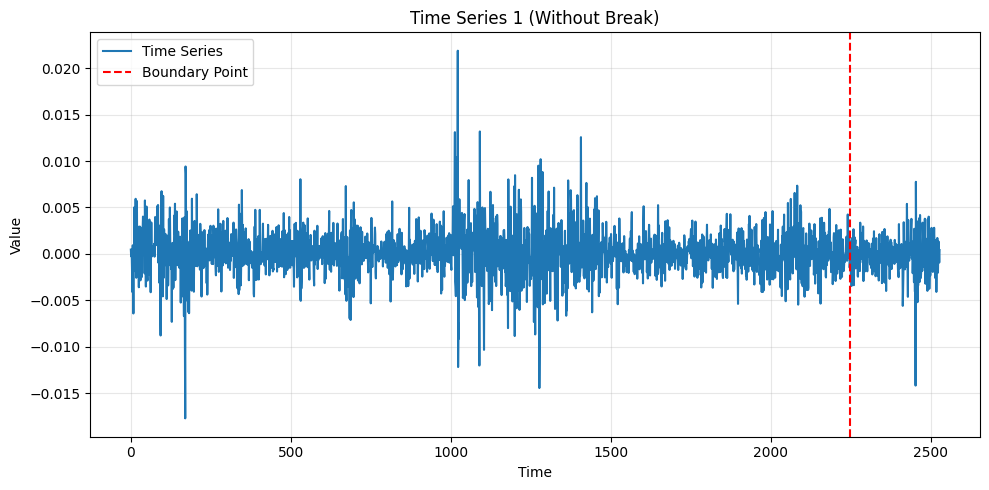

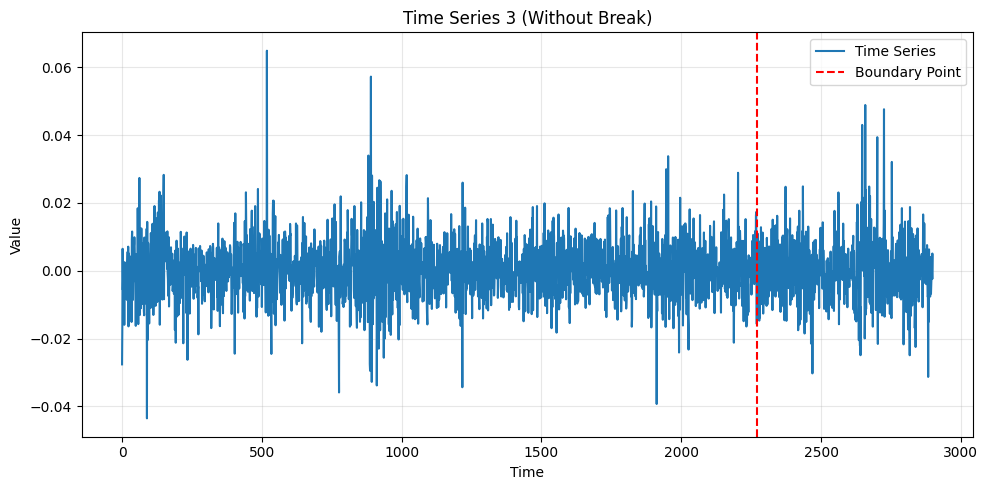

In [43]:
# Let's visualize a few examples to understand the data better
import matplotlib.pyplot as plt
import random
from matplotlib.gridspec import GridSpec

# Function to plot a time series with the boundary point
def plot_time_series(series, has_break=None, title=None):
    fig = plt.figure(figsize=(10, 5))

    # Find the boundary point (where period changes from 0 to 1)
    boundary_idx = series[series['period'] == 1].index[0] if any(series['period'] == 1) else None

    # Plot the time series
    plt.plot(series.index, series['value'], label='Time Series')

    # Add a vertical line at the boundary point
    if boundary_idx is not None:
        plt.axvline(x=boundary_idx, color='r', linestyle='--', label='Boundary Point')

    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Value')
    if title:
        plt.title(title)
    elif has_break is not None:
        plt.title(f"Time Series with{'' if has_break else 'out'} Structural Break")
    else:
        plt.title("Time Series with Boundary Point")

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Get some example IDs with and without breaks
break_ids = y_train[y_train == True].index[:3]
no_break_ids = y_train[y_train == False].index[:3]

# Plot a few examples with breaks
print("Examples WITH structural breaks:")
for id_val in break_ids:
    series = X_train.loc[id_val].reset_index()
    plot_time_series(series, has_break=True, title=f"Time Series {id_val} (With Break)")

# Plot a few examples without breaks
print("Examples WITHOUT structural breaks:")
for id_val in no_break_ids:
    series = X_train.loc[id_val].reset_index()
    plot_time_series(series, has_break=False, title=f"Time Series {id_val} (Without Break)")


### Understanding `y_train`

This is a simple `pandas.Series` that tells if a dataset id has a structural breakpoint or not.

**Index:**
- `id`: the ID of the dataset

**Value:**
- `structural_breakpoint`: Boolean indicating whether a structural break occurred (`True`) or not (`False`)

In [44]:
y_train

,structural_breakpoint
id,
0,False
1,False
2,True
3,False
4,False
...,...
9996,False
9997,False
9998,False


### Understanding `X_test`

The test data is provided as a **`list` of `pandas.DataFrame`s** with the same format as [`X_train`](#understanding-X_test).

It is structured as a list to encourage processing records one by one, which will be mandatory in the `infer()` function.

In [45]:
print("Number of datasets:", len(X_test))

Number of datasets: 101


In [46]:
X_test[0]

value  period
id    time                  
10001 0     0.010753       0
      1    -0.031915       0
      2    -0.010989       0
      3    -0.011111       0
      4     0.011236       0
...              ...     ...
      2774 -0.013937       1
      2775 -0.015649       1
      2776 -0.009744       1
      2777  0.025375       1
      2778 -0.001515       1

[2779 rows x 2 columns]

## Strategy Implementation

There are multiple approaches you can take to detect structural breaks:

1. **Statistical Tests**: Compare distributions before and after the boundary point;
2. **Feature Engineering**: Extract features from both segments for comparison;
3. **Time Series Modeling**: Detect deviations from expected patterns;
4. **Machine Learning**: Train models to recognize break patterns from labeled examples.

The baseline implementation below uses a simple statistical approach: a t-test to compare the distributions before and after the boundary point.

### The `train()` Function

In this function, you build and train your model for making inferences on the test data. Your model must be stored in the `model_directory_path`.

The baseline implementation below doesn't require a pre-trained model, as it uses a statistical test that will be computed at inference time.

In [47]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    # Step 1: Extract features from all training time series
    print("Extracting features from training data...")
    features_df = extract_features_from_multiple_series(X_train)

    # Step 2: Align features with labels
    # This makes sure we have the same IDs in features and labels
    common_ids = features_df.index.intersection(y_train.index)
    X = features_df.loc[common_ids]
    y = y_train.loc[common_ids]

    print(f"Training model with {len(X)} examples...")

    # Step 3: Create and train the model
    # Using RandomForest classifier with StandardScaler in a pipeline
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    # Fit the model
    model.fit(X, y)

    # Step 4: Save the model
    print("Saving model...")
    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))

    # Step 5: Also save the feature names for inference
    feature_names = X.columns.tolist()
    joblib.dump(feature_names, os.path.join(model_directory_path, 'feature_names.joblib'))

    print("Training completed!")
    return model

### The `infer()` Function

In the inference function, your trained model (if any) is loaded and used to make predictions on test data.

**Important workflow:**
1. Load your model;
2. Use the `yield` statement to signal readiness to the runner;
3. Process each dataset one by one within the for loop;
4. For each dataset, use `yield prediction` to return your prediction.

**Note:** The datasets can only be iterated once!

In [48]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    # Load the trained model and feature names
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))
    feature_names = joblib.load(os.path.join(model_directory_path, 'feature_names.joblib'))

    yield  # Mark as ready

    # X_test can only be iterated once
    # Before getting the next dataset, you must predict the current one
    for dataset in X_test:
        # Extract features for this time series
        features = extract_features(dataset)

        # Convert features to DataFrame with the right structure
        features_df = pd.DataFrame([features])

        # Make sure we have all the expected features in the right order
        for feature in feature_names:
            if feature not in features_df.columns:
                features_df[feature] = 0.0

        features_df = features_df[feature_names]  # Reorder columns to match training data

        # Get the prediction probability for class 1 (structural break)
        try:
            prediction = model.predict_proba(features_df)[0, 1]
        except:
            # Fallback to t-test if there's an error with the model
            def t_test(u: pd.DataFrame):
                return -scipy.stats.ttest_ind(
                    u["value"][u["period"] == 0],  # Values before boundary point
                    u["value"][u["period"] == 1],  # Values after boundary point
                ).pvalue
            prediction = t_test(dataset)
            # Convert to probability-like scale
            prediction = 1 / (1 + np.exp(prediction))  # Sigmoid transformation

        yield prediction  # Send the prediction for the current dataset

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [49]:
crunch.test(
    # Uncomment to disable the train
    # force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)

05:28:07 no forbidden library found
05:28:07 
05:28:07 started
05:28:07 running local test
05:28:07 internet access isn't restricted, no check will be done
05:28:07 
05:28:08 starting unstructured loop...
05:28:08 executing - command=train


data/X_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match
Extracting features from training data...
Training model with 10001 examples...


05:31:33 executing - command=infer


Saving model...
Training completed!


05:31:40 checking determinism by executing the inference again with 30% of the data (tolerance: 1e-08)
05:31:40 executing - command=infer
05:31:42 determinism check: passed
05:31:42 save prediction - path=data/prediction.parquet
05:31:42 ended
05:31:42 duration - time=00:03:35
05:31:42 memory - before="3.31 GB" after="2.86 GB" consumed="-449146880 bytes"


In [50]:
# Analyze feature importance if we have a trained model
import matplotlib.pyplot as plt

if os.path.exists(os.path.join('model', 'model.joblib')):
    try:
        model = joblib.load(os.path.join('model', 'model.joblib'))
        feature_names = joblib.load(os.path.join('model', 'feature_names.joblib'))

        if hasattr(model, 'named_steps') and 'classifier' in model.named_steps:
            # Extract the classifier from the pipeline
            classifier = model.named_steps['classifier']

            if hasattr(classifier, 'feature_importances_'):
                # Create a DataFrame of feature importances
                importances = pd.DataFrame({
                    'feature': feature_names,
                    'importance': classifier.feature_importances_
                })

                # Sort by importance
                importances = importances.sort_values('importance', ascending=False)

                # Display top 20 features
                print("Top 20 most important features:")
                display(importances.head(20))

                # Plot feature importance
                plt.figure(figsize=(12, 8))
                plt.barh(importances.head(15)['feature'], importances.head(15)['importance'])
                plt.xlabel('Importance')
                plt.ylabel('Feature')
                plt.title('Top 15 Feature Importances')
                plt.gca().invert_yaxis()  # Display most important feature at the top
                plt.tight_layout()
                plt.show()
    except Exception as e:
        print(f"Could not analyze feature importance: {e}")
else:
    print("No trained model found. Run crunch.test() first.")


No trained model found. Run crunch.test() first.


## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [51]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

,prediction
id,
10001,0.25
10002,0.21
10003,0.34
10004,0.21
10005,0.31
...,...
10097,0.30
10098,0.20
10099,0.32


### Local scoring

You can call the function that the system uses to estimate your score locally.

In [52]:
# Perform cross-validation to estimate model performance
from sklearn.model_selection import cross_val_score, StratifiedKFold

def evaluate_model_with_cv():
    # Extract features for all training data
    print("Extracting features for cross-validation...")
    features_df = extract_features_from_multiple_series(X_train)

    # Align with labels
    common_ids = features_df.index.intersection(y_train.index)
    X = features_df.loc[common_ids]
    y = y_train.loc[common_ids]

    # Create the model pipeline
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Perform stratified 5-fold cross-validation
    print("Performing 5-fold cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    print(f"Cross-validation ROC AUC scores: {cv_scores}")
    print(f"Mean ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    return cv_scores

# Run cross-validation
try:
    cv_scores = evaluate_model_with_cv()
except Exception as e:
    print(f"Error during cross-validation: {e}")


Extracting features for cross-validation...
Performing 5-fold cross-validation...
Cross-validation ROC AUC scores: [0.68872978 0.6651705  0.68513927 0.66981531 0.67435803]
Mean ROC AUC: 0.6766 ± 0.0090


In [53]:
# Hyperparameter tuning to find optimal model parameters
from sklearn.model_selection import RandomizedSearchCV

def tune_hyperparameters():
    # Extract features for all training data
    print("Extracting features for hyperparameter tuning...")
    features_df = extract_features_from_multiple_series(X_train)

    # Align with labels
    common_ids = features_df.index.intersection(y_train.index)
    X = features_df.loc[common_ids]
    y = y_train.loc[common_ids]

    # Create the model pipeline
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    # Define the parameter grid to search
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2', None]
    }

    # Use RandomizedSearchCV to find good parameters
    print("Performing randomized search for hyperparameter tuning...")
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(
        model, param_distributions=param_grid, n_iter=20, cv=cv,
        scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1
    )

    # Fit the randomized search
    random_search.fit(X, y)

    # Print best parameters and score
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best ROC AUC score: {random_search.best_score_:.4f}")

    return random_search.best_estimator_, random_search.best_score_

# Uncomment to run hyperparameter tuning (this may take a while)
# best_model, best_score = tune_hyperparameters()


In [54]:
# Ablation study to understand the importance of different feature groups
def perform_ablation_study():
    # Extract features for all training data
    print("Extracting features for ablation study...")
    features_df = extract_features_from_multiple_series(X_train)

    # Align with labels
    common_ids = features_df.index.intersection(y_train.index)
    X = features_df.loc[common_ids]
    y = y_train.loc[common_ids]

    # Define feature groups
    feature_groups = {
        'statistical_tests': [col for col in X.columns if any(x in col for x in ['test_stat', 'test_pvalue'])],
        'mean_features': [col for col in X.columns if 'mean' in col],
        'variance_features': [col for col in X.columns if any(x in col for x in ['var_', 'entropy'])],
        'skew_kurt_features': [col for col in X.columns if any(x in col for x in ['skew', 'kurt'])],
        'autocorrelation': [col for col in X.columns if 'acf' in col],
        'trend_features': [col for col in X.columns if 'trend' in col]
    }

    # Create a base model
    base_model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    # Perform cross-validation with all features (baseline)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    baseline_scores = cross_val_score(base_model, X, y, cv=cv, scoring='roc_auc')
    baseline_mean = baseline_scores.mean()

    print(f"Baseline (all features): Mean ROC AUC = {baseline_mean:.4f}")

    # Results dictionary
    results = {'baseline (all features)': baseline_mean}

    # For each feature group, leave it out and see the impact
    for group_name, group_features in feature_groups.items():
        # Features to keep (all except the current group)
        keep_features = [col for col in X.columns if col not in group_features]

        # Skip if too few features remain
        if len(keep_features) < 5:
            print(f"Skipping {group_name} (too few features would remain)")
            continue

        # Prepare data without this feature group
        X_subset = X[keep_features]

        # Perform cross-validation
        scores = cross_val_score(base_model, X_subset, y, cv=cv, scoring='roc_auc')
        mean_score = scores.mean()

        # Calculate importance
        importance = baseline_mean - mean_score

        results[f'without {group_name}'] = mean_score
        print(f"Without {group_name}: Mean ROC AUC = {mean_score:.4f} (Difference: {importance:.4f})")

    # Bar chart of results
    plt.figure(figsize=(12, 6))
    plt.bar(results.keys(), results.values())
    plt.axhline(y=baseline_mean, color='r', linestyle='--', label='Baseline score')
    plt.xlabel('Feature Group Removed')
    plt.ylabel('Mean ROC AUC')
    plt.title('Feature Group Importance (Ablation Study)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend()
    plt.show()

    return results

# Uncomment to run ablation study
# ablation_results = perform_ablation_study()


In [55]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

np.float64(0.6352112676056337)

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)